In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
from collections import defaultdict

In [40]:
# Sample dataset (customer transactions)
data = [
    ['A', 'B', 'C'],
    ['A', 'C'],
    ['A', 'B'],
    ['B', 'C', 'D'],
    ['A', 'B', 'C', 'D'],
    ['A', 'D', 'E'],
    ['B', 'C', 'E'],
    ['A', 'B', 'E'],
    ['C', 'D', 'E'],
    ['A', 'C', 'D'],
    ['B', 'C', 'D', 'E'],
    ['A', 'B', 'C', 'E'],
    ['D', 'E'],
    ['A', 'E'],
    ['B', 'D'],
    ['C', 'E'],
    ['A', 'B', 'D', 'E'],
    ['B', 'C'],
    ['A', 'B', 'C', 'D', 'E'],
    ['B', 'E']
]

In [41]:
df = pd.DataFrame({'sequence': data})

Check if seq is a subsequence of full_seq
    
Args:
    seq: The subsequence to check
    full_seq: The full sequence
        
Returns:
    Boolean indicating if seq is a subsequence of full_seq

In [42]:
# Function to check if sequence is a subsequence of another sequence
def is_subsequence(seq, full_seq):
    if not seq:
        return True
    
    if not full_seq:
        return False
    
    i, j = 0, 0
    while i < len(seq) and j < len(full_seq):
        if seq[i] == full_seq[j]:
            i += 1
        j += 1
    
    return i == len(seq)

Count how many times a sequence appears in the dataset
    
Args:
    sequence: The sequence to count
    df: DataFrame containing the sequences
        
Returns:
    Integer count of occurrences

In [43]:
# Function to count sequence support
def count_support(sequence, df):
    
    count = 0
    for seq in df['sequence']:
        if all(item in seq for item in sequence):
            count += 1
    return count

Count how many times a sequence appears in the dataset in the correct order
    
Args:
    sequence: The sequence to count
    df: DataFrame containing the sequences
        
Returns:
    Integer count of occurrences

In [44]:
# Function to count support using subsequence approach
def count_support_ordered(sequence, df):
    
    count = 0
    for seq in df['sequence']:
        if is_subsequence(sequence, seq):
            count += 1
    return count

Implement the GSP algorithm to find frequent sequential patterns
    
Args:
    df: DataFrame containing sequences
    min_support: Minimum support threshold
    max_length: Maximum length of patterns to find
    ordered: Boolean indicating if order matters
        
Returns:
    List of tuples containing (sequence, support)

In [45]:
# Generalized Sequential Pattern (GSP) Algorithm
def gsp_algorithm(df, min_support, max_length=None, ordered=False):
    # Get unique items in the dataset
    unique_items = set()
    for seq in df['sequence']:
        unique_items.update(seq)
    
    # Generate candidate 1-sequences
    C1 = [(item,) for item in unique_items]
    
    # Count support for candidates
    L1 = []
    for candidate in C1:
        support = count_support_ordered(candidate, df) if ordered else count_support(candidate, df)
        if support >= min_support:
            L1.append((candidate, support))
    
    # Sort by support (descending)
    L1.sort(key=lambda x: x[1], reverse=True)
    
    # Initialize result with frequent 1-sequences
    result = L1.copy()
    
    k = 2
    current_L = L1
    
    # Continue until no more frequent sequences or max_length is reached
    while current_L and (max_length is None or k <= max_length):
        # Extract sequences from current_L
        current_sequences = [x[0] for x in current_L]
        
        # Generate candidate k-sequences
        Ck = []
        for i in range(len(current_sequences)):
            for j in range(len(current_sequences)):
                if i != j:
                    # Join sequences
                    if ordered:
                        # For ordered sequences
                        if current_sequences[i][:-1] == current_sequences[j][1:]:
                            new_seq = current_sequences[i] + (current_sequences[j][-1],)
                            Ck.append(new_seq)
                    else:
                        # For unordered sequences (join if first k-2 elements are the same)
                        if k > 2 and current_sequences[i][:-1] == current_sequences[j][:-1]:
                            new_seq = current_sequences[i] + (current_sequences[j][-1],)
                            if new_seq not in Ck:
                                Ck.append(new_seq)
                        elif k == 2:
                            new_seq = current_sequences[i] + current_sequences[j]
                            if new_seq not in Ck:
                                Ck.append(new_seq)
        
        # Count support for candidates
        Lk = []
        for candidate in Ck:
            support = count_support_ordered(candidate, df) if ordered else count_support(candidate, df)
            if support >= min_support:
                Lk.append((candidate, support))
        
        # Sort by support (descending)
        Lk.sort(key=lambda x: x[1], reverse=True)
        
        # Add to result
        result.extend(Lk)
        
        # Update for next iteration
        current_L = Lk
        k += 1
    
    return result

Optimized implementation of the GSP algorithm
    
Args:
    df: DataFrame containing sequences
    min_support: Minimum support threshold
    max_length: Maximum length of patterns to find
        
Returns:
    List of tuples containing (sequence, support)

In [46]:
# Optimized GSP Algorithm with better candidate generation
def optimized_gsp(df, min_support, max_length=None):
    # Count single item occurrences
    item_counts = defaultdict(int)
    for seq in df['sequence']:
        for item in set(seq):
            item_counts[item] += 1
    
    # Filter frequent single-item sequences
    L1 = [(tuple([item]), support) for item, support in item_counts.items() 
          if support >= min_support]
    
    # Sort by support (descending)
    L1.sort(key=lambda x: x[1], reverse=True)
    
    # Initialize result with frequent 1-sequences
    result = L1.copy()
    
    k = 2
    current_L = L1
    
    # Continue until no more frequent sequences or max_length is reached
    while current_L and (max_length is None or k <= max_length):
        candidate_sequences = [seq for seq, _ in current_L]
        
        # Generate new candidate sequences more efficiently
        Ck = []
        for seq1, seq2 in itertools.combinations(candidate_sequences, 2):
            # Join if first k-2 elements are the same
            if k == 2 or (k > 2 and seq1[:-1] == seq2[:-1]):
                new_seq = seq1 + (seq2[-1],)
                
                # Check if all subsequences are frequent (pruning step)
                valid = True
                for sub_idx in itertools.combinations(range(len(new_seq)), k-1):
                    sub_seq = tuple(new_seq[i] for i in sub_idx)
                    if sub_seq not in candidate_sequences:
                        valid = False
                        break
                
                if valid and new_seq not in Ck:
                    Ck.append(new_seq)
        
        # Count support for candidates
        Lk = []
        for candidate in Ck:
            support = count_support(candidate, df)
            if support >= min_support:
                Lk.append((candidate, support))
        
        # Sort by support (descending)
        Lk.sort(key=lambda x: x[1], reverse=True)
        
        # Add to result
        result.extend(Lk)
        
        # Update for next iteration
        current_L = Lk
        k += 1
    
    return result

Compare different algorithms on various parameters
    
Args:
    df: DataFrame containing sequences
    min_support_values: List of minimum support thresholds to test
    algorithms: Dictionary mapping algorithm names to functions
        
Returns:
    DataFrame with performance metrics

In [47]:
# Function to run performance comparison
def compare_algorithms(df, min_support_values, algorithms):
    results = []
    
    for min_support in min_support_values:
        for algo_name, algo_func in algorithms.items():
            start_time = time.time()
            frequent_sequences = algo_func(df, min_support)
            execution_time = time.time() - start_time
            
            results.append({
                'Algorithm': algo_name,
                'Min Support': min_support,
                'Patterns Found': len(frequent_sequences),
                'Execution Time (s)': execution_time
            })
    
    return pd.DataFrame(results)

Create visualizations for the discovered patterns
    
Args:
    frequent_sequences: List of (sequence, support) tuples
    title: Title for the plot

In [48]:
# Function to visualize the discovered patterns
def visualize_patterns(frequent_sequences, title="Frequent Patterns"):
    # Extract sequences and support values
    sequences = [' → '.join(seq) for seq, _ in frequent_sequences]
    supports = [support for _, support in frequent_sequences]
    
    # Sort by support (descending)
    combined = list(zip(sequences, supports))
    combined.sort(key=lambda x: x[1], reverse=True)
    
    # Take top 15 for better visualization
    top_n = 15
    if len(combined) > top_n:
        combined = combined[:top_n]
    
    sequences, supports = zip(*combined)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(sequences))
    plt.barh(y_pos, supports, align='center')
    plt.yticks(y_pos, sequences)
    plt.xlabel('Support Count')
    plt.ylabel('Sequential Patterns')
    plt.title(title)
    plt.tight_layout()
    
    # Display the plot directly instead of saving it
    plt.show()

Dataset Information:
Number of sequences: 20
Unique items: 5 {'E', 'C', 'B', 'D', 'A'}
Average sequence length: 2.90

Running GSP Algorithm...
GSP found 79 patterns in 0.0030 seconds

Running Optimized GSP Algorithm...
Optimized GSP found 24 patterns in 0.0004 seconds

Frequent Patterns (Optimized GSP, min_support=3):
 Sequence  Support
        B       13
        C       12
        E       12
        A       11
        D       10
    B → C        8
    B → E        7
    B → A        7
    B → D        6
    C → E        6
    C → A        6
    C → D        6
    E → A        6
    E → D        6
    A → D        5
B → C → E        4
B → C → A        4
B → C → D        4
B → E → A        4
B → E → D        3
B → A → D        3
C → E → D        3
C → A → D        3
E → A → D        3

Algorithm Comparison:
    Algorithm  Min Support  Patterns Found  Execution Time (s)
          GSP            2             181            0.005002
Optimized GSP            2              29            0.

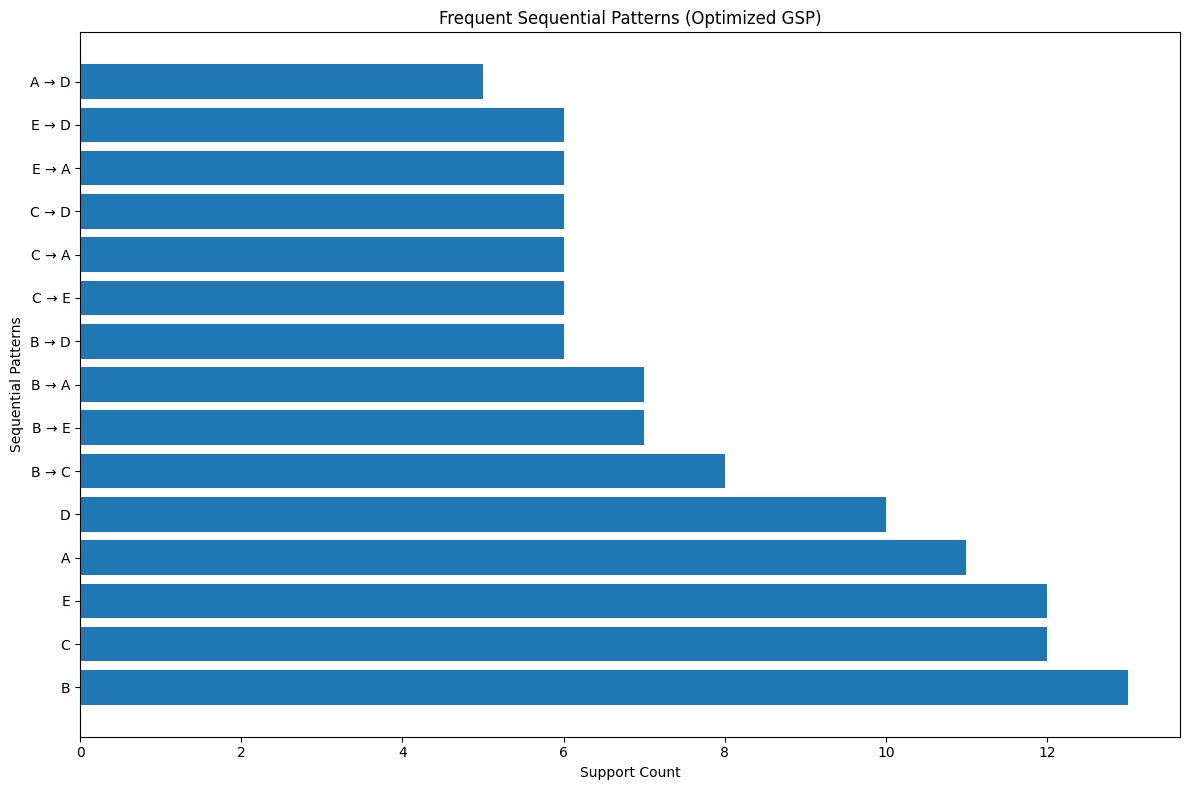


Parameter Tuning: Impact of Minimum Support
Min Support: 2
  Total Patterns: 29
  Execution Time: 0.0004s
  Pattern Length Distribution: {1: 5, 2: 10, 3: 10, 4: 4}
Min Support: 3
  Total Patterns: 24
  Execution Time: 0.0003s
  Pattern Length Distribution: {1: 5, 2: 10, 3: 9}
Min Support: 4
  Total Patterns: 19
  Execution Time: 0.0003s
  Pattern Length Distribution: {1: 5, 2: 10, 3: 4}
Min Support: 5
  Total Patterns: 15
  Execution Time: 0.0002s
  Pattern Length Distribution: {1: 5, 2: 10}
Min Support: 6
  Total Patterns: 14
  Execution Time: 0.0002s
  Pattern Length Distribution: {1: 5, 2: 9}
Min Support: 7
  Total Patterns: 8
  Execution Time: 0.0001s
  Pattern Length Distribution: {1: 5, 2: 3}


In [49]:
if __name__ == "__main__":
    # Print dataset information
    print("Dataset Information:")
    print(f"Number of sequences: {len(df)}")
    unique_items = set()
    for seq in df['sequence']:
        unique_items.update(seq)
    print(f"Unique items: {len(unique_items)} {unique_items}")
    print(f"Average sequence length: {sum(len(seq) for seq in df['sequence']) / len(df):.2f}")
    print()
    
    # Set parameters
    min_support = 3
    
    print("Running GSP Algorithm...")
    start_time = time.time()
    frequent_sequences = gsp_algorithm(df, min_support)
    gsp_time = time.time() - start_time
    print(f"GSP found {len(frequent_sequences)} patterns in {gsp_time:.4f} seconds")
    
    print("\nRunning Optimized GSP Algorithm...")
    start_time = time.time()
    frequent_sequences_opt = optimized_gsp(df, min_support)
    opt_time = time.time() - start_time
    print(f"Optimized GSP found {len(frequent_sequences_opt)} patterns in {opt_time:.4f} seconds")
    
    # Display results in a nicely formatted table
    print("\nFrequent Patterns (Optimized GSP, min_support=3):")
    results_df = pd.DataFrame(frequent_sequences_opt, columns=['Sequence', 'Support'])
    results_df['Sequence'] = results_df['Sequence'].apply(lambda x: ' → '.join(x))
    results_df = results_df.sort_values('Support', ascending=False)
    print(results_df.to_string(index=False))
    
    # Compare algorithms with different minimum support values
    min_support_values = [2, 3, 4, 5]
    algorithms = {
        'GSP': gsp_algorithm,
        'Optimized GSP': optimized_gsp
    }
    
    comparison_results = compare_algorithms(df, min_support_values, algorithms)
    print("\nAlgorithm Comparison:")
    print(comparison_results.to_string(index=False))
    
    # Visualize the discovered patterns (will display in output cell)
    visualize_patterns(frequent_sequences_opt, "Frequent Sequential Patterns (Optimized GSP)")
    
    # Parameter tuning analysis
    print("\nParameter Tuning: Impact of Minimum Support")
    tuning_results = []
    for min_sup in range(2, 8):
        start_time = time.time()
        patterns = optimized_gsp(df, min_sup)
        exec_time = time.time() - start_time
        
        # Count patterns by length
        pattern_lengths = {}
        for pat, _ in patterns:
            length = len(pat)
            pattern_lengths[length] = pattern_lengths.get(length, 0) + 1
        
        tuning_results.append({
            'Min Support': min_sup,
            'Total Patterns': len(patterns),
            'Execution Time (s)': exec_time,
            'Pattern Lengths': pattern_lengths
        })
    
    for result in tuning_results:
        print(f"Min Support: {result['Min Support']}")
        print(f"  Total Patterns: {result['Total Patterns']}")
        print(f"  Execution Time: {result['Execution Time (s)']:.4f}s")
        print(f"  Pattern Length Distribution: {result['Pattern Lengths']}")